In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [3]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import matplotlib
import kabuki
from matplotlib import pyplot as plt
import ipyparallel
from ipyparallel import parallel
import hddm
import os

%matplotlib inline
np.set_printoptions(suppress = True)

In [8]:
os.chdir("/Users/user/Desktop/Experiments/Nick/AttentionSaccade")
sublist = [1,2,3,4,5,6,7,8,9]

datafname = os.path.join(os.getcwd(), 'AttentionSaccade_BehaviouralData_All.csv')
data = pd.read_csv(datafname, sep = ',', index_col = False) #read in collated data
data = data.drop(data.columns[0], axis = 1) #drop unnamed, random column that has appeared in the data
attention = data.loc[data['task']==1]
saccade   = data.loc[data['task']==2]
attention.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

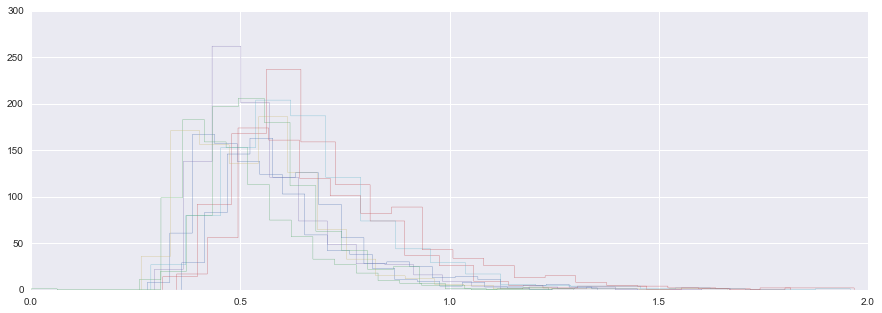

In [9]:
plt.rcParams['figure.figsize'] = (15,5)
for i, subject in attention.groupby('subject'):
    subject.time.hist(bins = 20, histtype = 'step')

In [10]:
attention = attention[['subject', 'time', 'corr', 'validity']] #select dataframe down to just these variables
attention = attention.rename(columns={'time':'rt', "corr":'response','subject':'subj_idx'}) #rename for use with hddm package
attention = attention[np.isnan(attention['rt'])==False] #remove trials with no response

attval = attention[attention['validity']==1]
attinv = attention[attention['validity']==0]

#rename colding of validity to string instead of number
attention.loc[attention.validity==1, 'validity'] = 'valid'
attention.loc[attention.validity==0, 'validity'] = 'invalid'
print attval.shape, attinv.shape

#attention.shape
#attention = attention[attention['rt']<0.05]
#np.where(np.isnan(attention['rt'])) #check for missing data

(6891, 4) (1721, 4)


In [24]:
#drift diffusion model on attention task data
model = hddm.HDDM(data= attention, p_outlier=0.05, bias = True, trace_subjs = True, std_depends = True,
                 depends_on = {'a':'validity', 'v':'validity',
                               't':'validity', 'z':'validity',
                               'sv':'validity', 'st':'validity'},
                 include = {'sv', 'st'}) #depends_on : model parameters estimated separately for validity conditions (so we can look at validity effect on model parameters)
model.find_starting_values()
model.sample(2000, burn=20)

stats = model.gen_stats()
stats
# a, v, t, z parameters for each participant, and the group (mean + stds)
# a = decision threshold
# v = drift rate
# t = non-decision time parameter
# z = prepotent response bias

 [-----------------100%-----------------] 2001 of 2000 complete in 41766.6 sec

In [128]:
#subset model parameter statistics to single subject parameters for plotting
indices = ['a(valid)' , 'a(invalid)' ,'a_std' , 'v(valid)' , 'v(invalid)' ,'v_std' ,
           't(valid)' , 't(invalid)' ,'t_std' , 'z(valid)' , 'z(invalid)' ,'z_std', 'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)']
#           'sv(valid)', 'sv(invalid)', 'st(valid)', 'st(invalid)'])
stats = pd.DataFrame(stats)
plotsub_stats = stats.drop(indices); plotsub_stats = pd.DataFrame(plotsub_stats.loc[:,'mean'])
plotsub_stats['modelparam'] = np.sort(np.tile(range(1,5),18))
plotsub_stats['validity']   = np.tile([1,2],36)
plotsub_stats['subject']    = np.tile(np.sort(np.tile(range(1,10), 2)),4)

plotsub_stats.loc[plotsub_stats.modelparam ==1, 'modelparam'] = 'a'; plotsub_stats.loc[plotsub_stats.modelparam ==2, 'modelparam'] = 'v'
plotsub_stats.loc[plotsub_stats.modelparam ==3, 'modelparam'] = 't'; plotsub_stats.loc[plotsub_stats.modelparam ==4, 'modelparam'] = 'z'

plotsub_stats.loc[plotsub_stats.validity==1, 'validity'] = 'invalid';plotsub_stats.loc[plotsub_stats.validity==2, 'validity'] = 'valid'

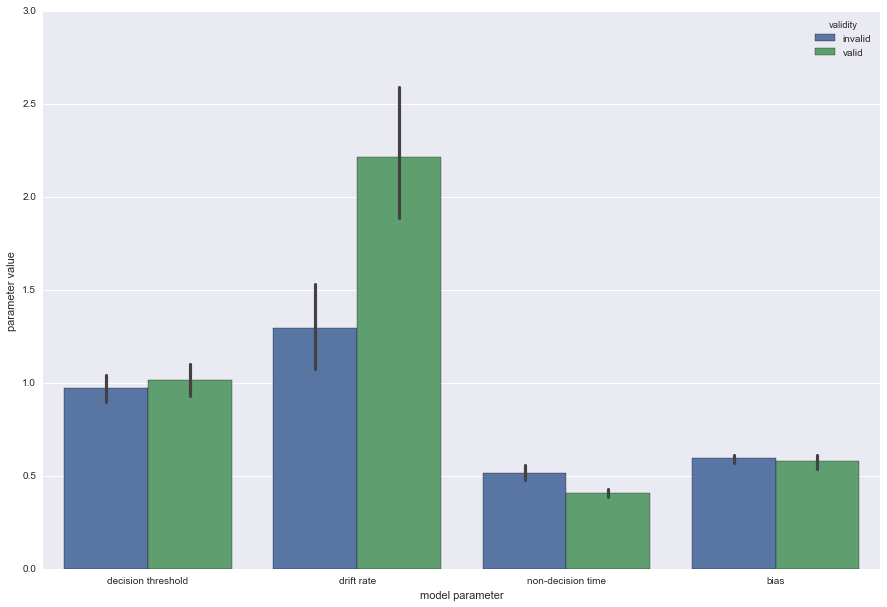

In [129]:
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.barplot(data = plotsub_stats, x = 'modelparam', hue = 'validity', y = 'mean')

ax.set_xticklabels(['decision threshold', 'drift rate', 'non-decision time', 'bias'])
ax.set_ylabel('parameter value'); ax.set_xlabel('model parameter')
plt.savefig(os.path.join(os.getcwd(), 'modelparameter_barplot_9subs'))

Plotting a(invalid)
Plotting a(valid)
Plotting a_std
Plotting v(invalid)
Plotting v(valid)
Plotting v_std
Plotting t(invalid)
Plotting t(valid)
Plotting t_std
Plotting sv(invalid)
Plotting sv(valid)
Plotting st(invalid)
Plotting st(valid)
Plotting z(invalid)
Plotting z(valid)
Plotting z_std


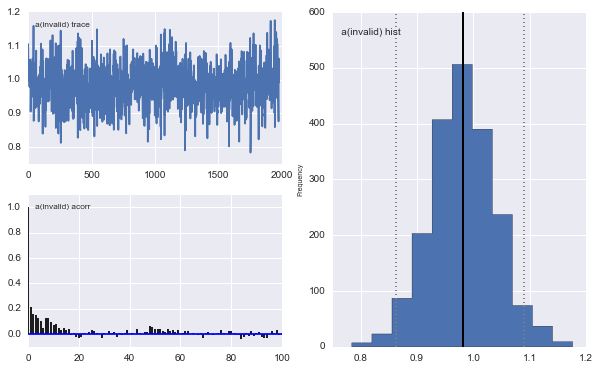

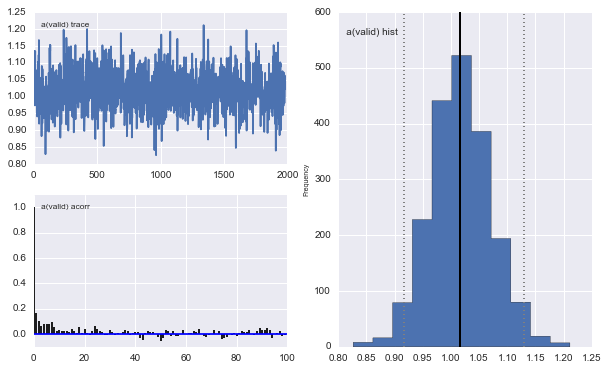

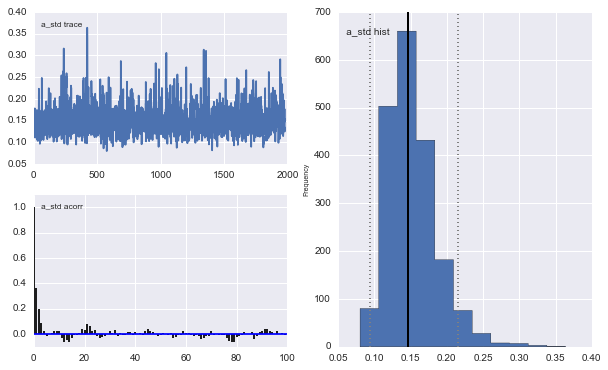

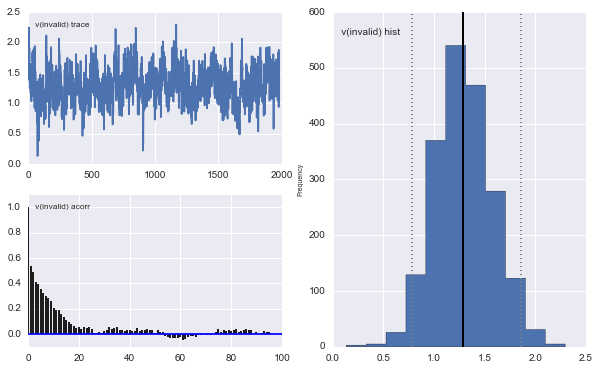

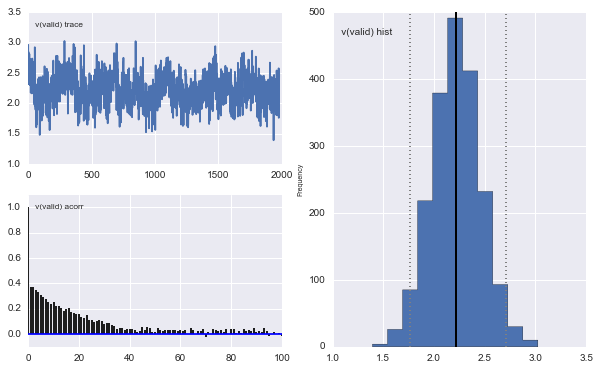

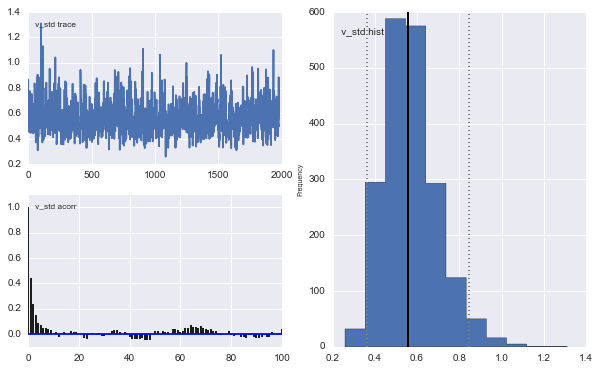

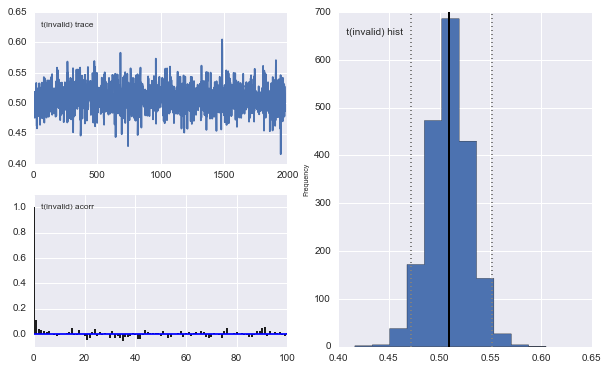

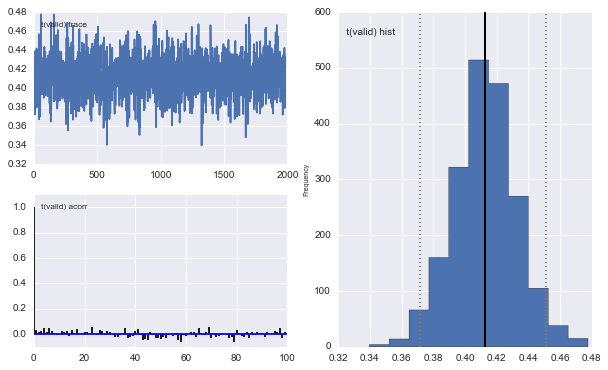

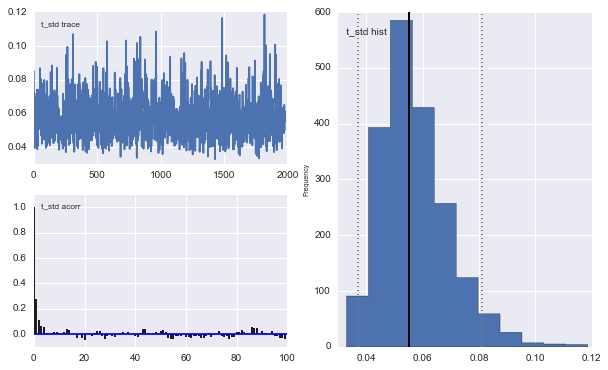

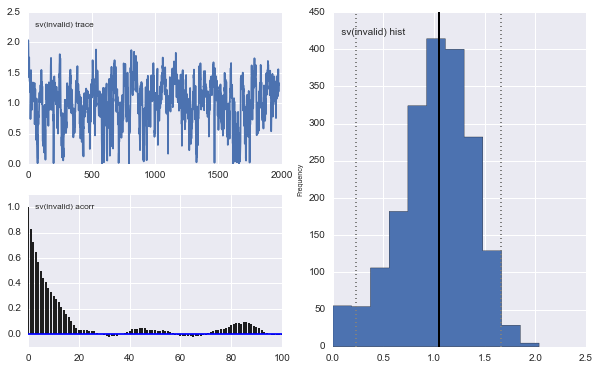

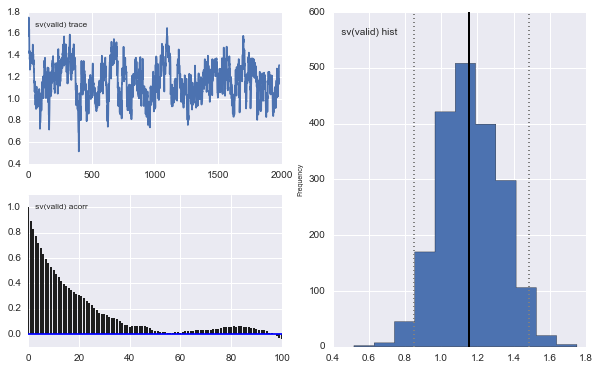

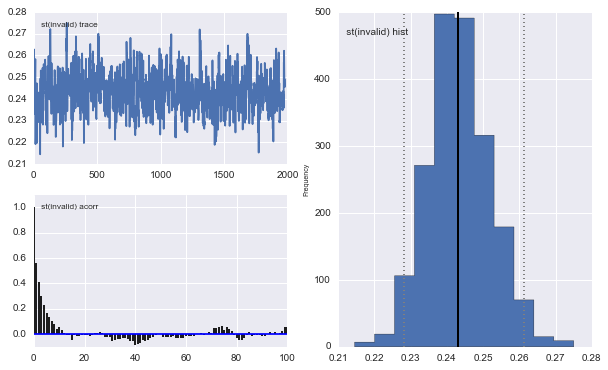

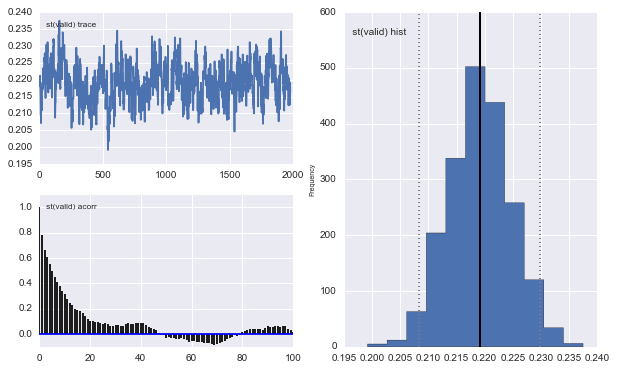

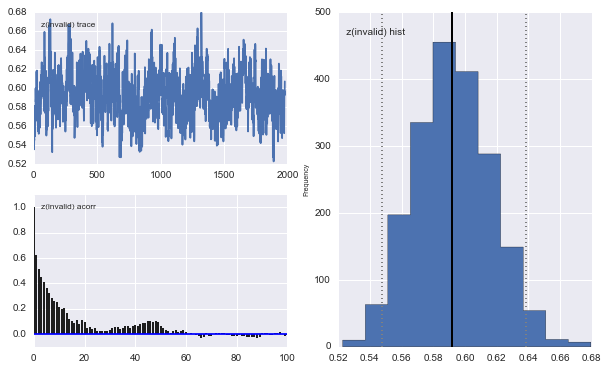

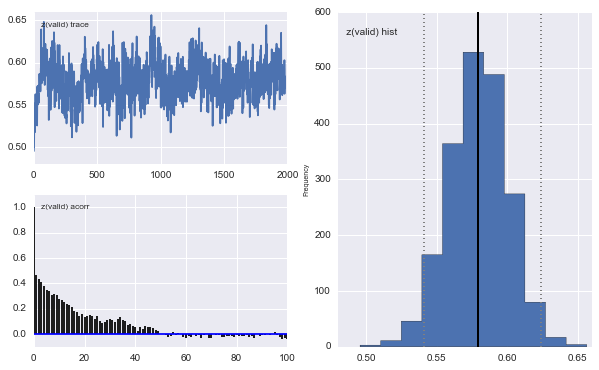

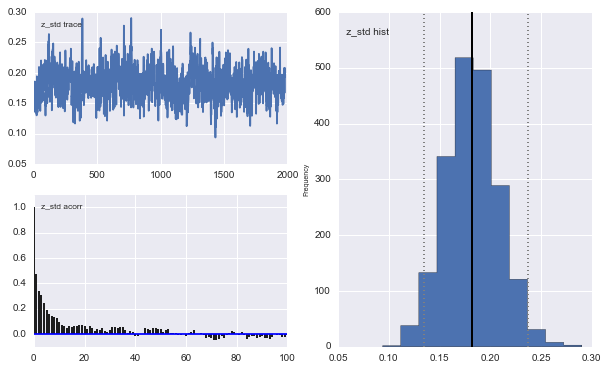

In [161]:
plt.rcParams['figure.figsize'] = (5,5)
posteriors = model.plot_posteriors_conditions
model.plot_posteriors()

In [185]:
sub_nodes = model.get_subj_nodes(stochastic=True)
grp_nodes = model.get_group_nodes(stochastic=True)
observeds = model.get_observeds()
stochasts = model.get_stochastics()
traces    = model.get_traces()

In [195]:
model['a(valid)']
#help(kabuki.analyze.plot_posterior_predictive)

<pymc.distributions.Gamma 'a(valid)' at 0x1170e11d0>

In [197]:
help(kabuki.Hierarchical)

Help on class Hierarchical in module kabuki.hierarchical:

class Hierarchical(__builtin__.object)
 |  Creation of hierarchical Bayesian models in which each subject
 |  has a set of parameters that are constrained by a group distribution.
 |  
 |  :Arguments:
 |      data : numpy.recarray
 |          Input data with a row for each trial.
 |          Must contain the following columns:
 |            * 'rt': Reaction time of trial in seconds.
 |            * 'response': Binary response (e.g. 0->error, 1->correct)
 |          May contain:
 |            * 'subj_idx': A unique ID (int) of the subject.
 |            * Other user-defined columns that can be used in depends_on
 |              keyword.
 |  
 |  :Optional:
 |      is_group_model : bool
 |          If True, this results in a hierarchical
 |          model with separate parameter distributions for each
 |          subject. The subject parameter distributions are
 |          themselves distributed according to a group parameter
 | 

In [ ]:
sim_data = hddm.utils.post_pred_gen(model)